# Intro and theory
Dataset: HCP fMRI dataset, preprocessed and parcellated into 360 ROIs

Task: Observing shapes moving either randomly or appearing to interact "socially"
 
Question: how does the brain encode viewing social interaction?

ROIs: temporoparietal junction, superior temporal sulcus, medial prefrontal cortex, fusiform gyrus, occipital gyrus, amygdala, insula 

Model: 
- ROIs indicated above interact with each other throughout this process of observing social interaction
- We can measure this interaction via effective connectivity (e.g. Granger causality)
- Viewing social interaction will increase GC between the ROIs, whereas random motion will not (control: random network, such as lower visual areas) 

Approach:
- extract time series for every subject for these ROIs in both conditions
- calculate GC between them (multivariate GC? fit a VAR?)

Hypothesis: viewing social interaction increases connectivity between areas within the "social network" of the brain


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Parameters

In [2]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

# Loading functions

In [3]:
fname = "hcp_task.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/s4h8j/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [58]:
#@title Helper functions: get image index, load_timeseries, load_evs (provided)
def get_image_ids(name):
  """Get the 1-based image indices for runs in a given experiment.

    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files

  """
  run_ids = [
    i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code
  ]
  if not run_ids:
    raise ValueError(f"Found no data for '{name}''")
  return run_ids

def load_timeseries(subject, name, runs=None, concat=True, remove_mean=True):
  """Load timeseries data for a single subject.
  
  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment 
  offset = get_image_ids(name)[0]

  # Load each run's data
  bold_data = [
      load_single_timeseries(subject, offset + run, remove_mean) for run in runs
  ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(subject, bold_run, remove_mean=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = f"{HCP_DIR}/subjects/{subject}/timeseries"
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts

def load_evs(subject, name, condition):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    condition (str) : Name of condition

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name):
    task_key = BOLD_NAMES[id - 1]
    ev_file = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{condition}.txt"
    ev = dict(zip(["onset", "duration", "amplitude"], np.genfromtxt(ev_file).T))
    evs.append(ev)
  return evs

def condition_frames(run_evs, skip=0):
  """Identify timepoints corresponding to a given condition in each run.

  Args:
    run_evs (list of dicts) : Onset and duration of the event, per run
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    frames_list (list of 1D arrays): Flat arrays of frame indices, per run

  """
  frames_list = []
  for ev in run_evs:

    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)

    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)

    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]

    frames_list.append(np.concatenate(frames))

  return frames_list


def selective_average(timeseries_data, ev, skip=0):
  """Take the temporal mean across frames for a given condition.

  Args:
    timeseries_data (array or list of arrays): n_parcel x n_tp arrays
    ev (dict or list of dicts): Condition timing information
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    avg_data (1D array): Data averaged across selected image frames based
    on condition timing

  """
  # Ensure that we have lists of the same length
  if not isinstance(timeseries_data, list):
    timeseries_data = [timeseries_data]
  if not isinstance(ev, list):
    ev = [ev]
  if len(timeseries_data) != len(ev):
    raise ValueError("Length of `timeseries_data` and `ev` must match.")

  # Identify the indices of relevant frames
  frames = condition_frames(ev)

  # Select the frames from each image
  selected_data = []
  for run_data, run_frames in zip(timeseries_data, frames):
    selected_data.append(run_data[:, run_frames])

  # Take the average in each parcel
  avg_data = np.concatenate(selected_data, axis=-1).mean(axis=-1)

  return avg_data

Region info

In [65]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    myelin=regions[2].astype(np.float),
)

regions_table = pd.DataFrame.from_dict(region_info)
regions_table[regions_table['network']=='Visual1']
# Codes from text:
# STS: STSdp, STSda, STSvp, STSva
# temporo-parietal-occipital junction:  TPOJ1,  TPOJ2,  TPOJ3
# ACC and mPFC: 33pr,  p24pr,  a24pr,  p24,  a24,  p32pr,  a32pr,  d32,  p32,  s32,  8BM,  9m, 10v,  10r,  and 25
# fusiform gyrus: FFC
# insula: Ig

,name,network,myelin
0,R_V1,Visual1,2.20900
120,R_ProS,Visual1,2.04894
141,R_DVT,Visual1,2.01359
180,L_V1,Visual1,2.08324
300,L_ProS,Visual1,1.93961
321,L_DVT,Visual1,1.86390


In [16]:
# Finding indices of two ROI regions
regionsdf = pd.DataFrame.from_dict(region_info)
regionsdf[regionsdf['name'].str.contains("STS")]
STSidx = regionsdf.index[regionsdf['name'].str.contains("R_STS")].tolist() # get indices
TPOJidx = regionsdf.index[regionsdf['name'].str.contains("R_TPOJ")].tolist() # get indices

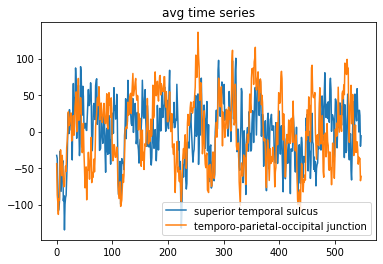

In [122]:
# Loading time series for two regions and plotting for 1 subject
all_ts = load_timeseries(29, "SOCIAL", runs=None, concat=True, remove_mean=True)
# average over all STS regions
STS_ts = np.mean(all_ts[STSidx,],axis=0)
plt.plot(STS_ts,label = 'superior temporal sulcus') #avg time series in STS
TPOJ_ts = np.mean(all_ts[TPOJidx,],axis=0)
plt.plot(TPOJ_ts,label = 'temporo-parietal-occipital junction')
plt.title('avg time series')
plt.legend()

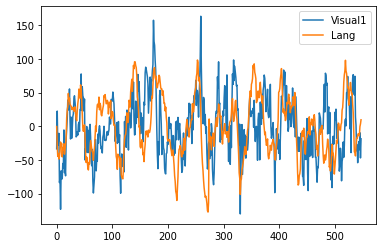

In [123]:
# Pick a random region to compare - V1
idx1 = regionsdf.index[regionsdf['network'].str.contains("Visual1")].tolist() # get indices
region1 = np.mean(all_ts[idx1,],axis = 0)
plt.plot(region1,label='Visual1') 
idx2 = regionsdf.index[regionsdf['network'].str.contains("Language")].tolist() # get indices
region2 = np.mean(all_ts[idx2,],axis = 0)
plt.plot(region2,label='Lang') 
plt.legend()
# Why do they overlap so much?

## Granger causality

In [130]:
from statsmodels.tsa.stattools import grangercausalitytests
# Checks if the TS in column 2 Granger-causes the TS in column 1
def GC_two_regions(all_ts, region_name1,region_name2):
  idx1 = regionsdf.index[regionsdf['name'].str.contains(region_name1)].tolist() # get indices
  region1 = np.mean(all_ts[idx1,],axis = 0)
  idx2 = regionsdf.index[regionsdf['name'].str.contains(region_name2)].tolist() # get indices
  region2 = np.mean(all_ts[idx2,],axis = 0)
  regions_combined = np.vstack((region1,region2)).T 
  grangercausalitytests(regions_combined,1,verbose=True)
GC_two_regions(all_ts, 'STS','TPOJ') # For the entire experiment


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5137  , p=0.0614  , df_denom=544, df_num=1
ssr based chi2 test:   chi2=3.5331  , p=0.0602  , df=1
likelihood ratio test: chi2=3.5217  , p=0.0606  , df=1
parameter F test:         F=3.5137  , p=0.0614  , df_denom=544, df_num=1


In [137]:
# Extract condition runs
subj_id = 0
task = 'SOCIAL'
all_ts_run0 = load_timeseries(subj_id, 'SOCIAL', runs=0) # Run 0
# Mentalizing
mental_frames = condition_frames(load_evs(subj_id, task, 'mental'))
mental_ts = all_ts_run0[:,mental_frames[0]]
# Random
random_frames = condition_frames(load_evs(subj_id, task, 'rnd'))
random_ts = all_ts_run0[:,random_frames[0]]
# Run GC
GC_two_regions(mental_ts, 'STS','TPOJ')
GC_two_regions(random_ts, 'STS','TPOJ')


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6842  , p=0.4114  , df_denom=60, df_num=1
ssr based chi2 test:   chi2=0.7184  , p=0.3967  , df=1
likelihood ratio test: chi2=0.7144  , p=0.3980  , df=1
parameter F test:         F=0.6842  , p=0.4114  , df_denom=60, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0060  , p=0.9384  , df_denom=92, df_num=1
ssr based chi2 test:   chi2=0.0062  , p=0.9372  , df=1
likelihood ratio test: chi2=0.0062  , p=0.9372  , df=1
parameter F test:         F=0.0060  , p=0.9384  , df_denom=92, df_num=1
